# Simulation of Simple Tank Level Controller

This notebook contains python code for a simple control scheme controlling the level of a tank. The control objective was to maintain the level of the tank near SP. Of course, if in your application the tank is a surge tank, different control objectives and strategies would likely be more effective, such as gain scheduling or gap control.  

Here, a cascade arrangement was used where the level controller writes the SP of the inner flow control loop. The flow control loop manipulates the position of the valve at the inlet of the tank. This is depicted in the figure below:  
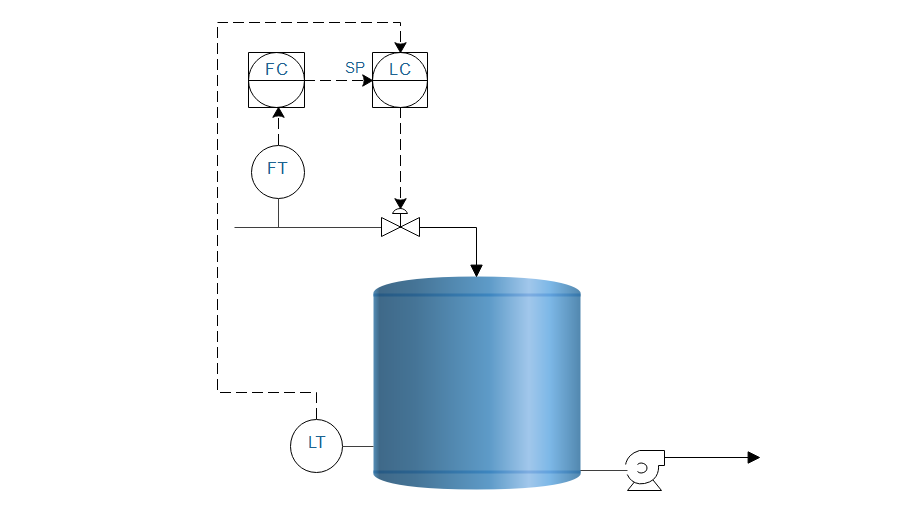

The code for the PID class was taken from [this](https://code.activestate.com/recipes/577231-discrete-pid-controller/) site with some slight modifications. These modifications include a clamp on the final PID output, the ability to define a scan time, and a switch of the algorithm from parallel to noninteractive/ISA. This is because, in my experience, PIDs from most of the DCS vendors are implemented with the noninteractive algorithm. Alternatively, it seems that the parallel form is often used in academia and PLCs. Finally, a quick inspection of the code shows that the position form of the PID equation was used. However the differences between the velocity and position forms for the end users are small.

Below is the PID class:

In [15]:
#Module goal: Define PID controller class
import math as m
import numpy as np
import control as ctr
import control.matlab as ml
import matplotlib.pyplot as plt

class PID:
	"""
	Discrete PID controller
	"""

	def __init__(self, Kc=2.0, I=0.0, D=1.0, Ts=1, Reverse=True, Derivator=0, Integrator=0, Integrator_max=500,
                 Integrator_min=-500):

		self.K=Kc
		self.Ki=I
		self.Kd=D
		self.Derivator=Derivator
		self.Integrator=Integrator
		self.Integrator_max=Integrator_max
		self.Integrator_min=Integrator_min
		self.Scan=Ts
		self.Reverse=Reverse
		self.set_point=0.0
		self.error=0.0

	def update(self,current_value):
		"""
		Calculate PID output value for given reference input and feedback
		"""

		if self.Reverse == True:
			self.error = self.set_point - current_value
		else:
			self.error = current_value - self.set_point
            
		self.P_value = self.K * self.error
		self.D_value = self.Kd*self.K * ( self.error - self.Derivator)
		self.Derivator = self.error

		self.Integrator = self.Integrator + self.error

		if self.Integrator > self.Integrator_max:
			self.Integrator = self.Integrator_max
		elif self.Integrator < self.Integrator_min:
			self.Integrator = self.Integrator_min

		self.I_value = self.Integrator * self.Ki * self.K * self.Scan

		PID = self.P_value + self.I_value + self.D_value
		if PID > 100:
			PID = 100
		elif PID < 0:
			PID = 0
        
		return PID

	def setPoint(self,set_point):
		"""
		Initilize the setpoint of PID
		"""
		self.set_point = set_point
		self.Integrator=0
		self.Derivator=0        
        
	def getPoint(self):
		return self.set_point

	def getError(self):
		return self.error

	def getIntegrator(self):
		return self.Integrator


Next we define the process (tank) and level controller, and we run a quick test. In this example, the tank has a maximum working height of 20 ft and a 10 ft diameter. 

1
60000


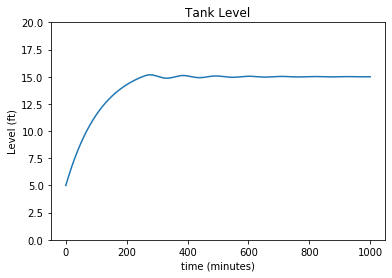

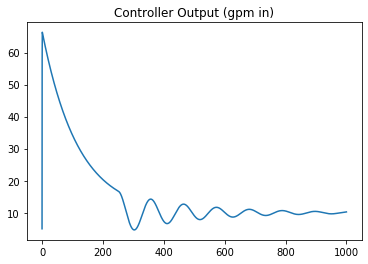

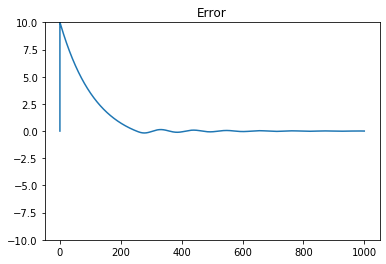

In [17]:
#Goal: Model cylindrical tank with dimensions h x d ft and inlet LCV
hmax = 20 #ft
d = 10 #ft
A = (d/2)**2*3.141*7.4808 #gal
Fout = 10 #gpm
Fin0 = 5
h0= 5 #ft

#initialize:
Fin = Fin0
h = h0

SP = 15 #ft
#e = SP - PV #Direct acting (valve on inlet)
dt = 1 #sec
Kc = 5
Ti = 150
Kd = 0

time = np.arange(0, 60000)
#PV = np.arange(0, len(time+1))
PV = [h0]
print(len(PV))
CO = [Fin0]
#P = [0]
I=[0]
e = [0]
                              
controller = PID( Kc, 1/Ti, Kd, Ts=dt)   #Ts entered in sec
controller.setPoint(15)

for t in time:

    Fin = controller.update(h)
    h =  (Fin - Fout)*(dt/60)/A + h
    
    PV.append(h)
    CO.append(Fin)
    I.append(controller.getIntegrator)
    e.append(controller.getError())
    
PV = np.asarray(PV[:len(time)])    
CO = np.asarray(CO[:len(time)])
I = np.asarray(I[:len(time)])
e = np.asarray(e[:len(time)])
time_min = time/60


print(len(PV))

fig, ax = plt.subplots()
ax.plot(time_min,PV)
ax.set_title("Tank Level")
ax.set_xlabel("time (minutes)")
ax.set_ylabel("Level (ft)")
#ax.set_xlim(0,len(time))
ax.set_ylim(0,20)
plt.show()
fig, ax = plt.subplots()
ax.plot(time_min,CO)
ax.set_title("Controller Output (gpm in)")
#ax.set_ylim(0,20)
plt.show()
fig, ax = plt.subplots()
ax.plot(time_min,e)
ax.set_title("Error")
ax.set_ylim(-10,10)
plt.show()


Great. One problem you may immediately notice is the kick from the effective SP change at initialization. You could implement a SP weighting (commonly done in industry) or update the initial parameters. 

On another note, some basic calculations tell me that we would expect a tank of that size to increase in level by 50% in 150 to 350 minutes. However, what we have implemented so far is a sort of level control valve. We still must add the flow controller and configure a cascade arrangement:

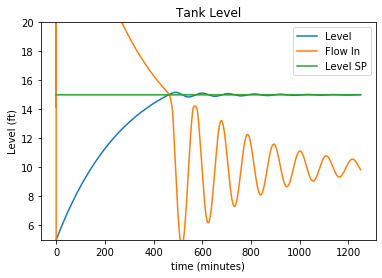

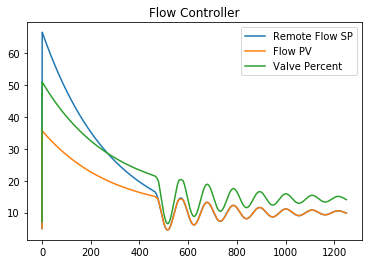

In [19]:
#Goal: Set up and integrate flow controller

#####Initialize level controller######

Fout = 10   #gpm
Fin0 = 5.01
h0= 5       #ft
Frsp = 5

Fin = Fin0
h = h0

SP = 15     #ft
dt = 1      #sec
Kc = 5
Ti = 150
Kd = 0


PV = [h0]
CO = [Frsp]
#P = [0]
I=[0]
e = [0]
          


#####Initialize flow controller######
SPf = Frsp   #gpm
Kcf = 1      #
Tif = 25     #sec
Kdf = 0

Flow_in = [Fin0]
COf = [7.14]  # % 
valve_perc = 7.14
#P = [0]
If=[0]
ef = [0]
                              
lvl_controller = PID( Kc, 1/Ti, Kd, Ts=dt)   #Ts entered in sec
lvl_controller.setPoint(SP)
flow_controller = PID(Kcf, 1/Tif, Kdf, Ts=dt)
flow_controller.setPoint(SPf)

Lvl_SP = [lvl_controller.getPoint()]

time = np.arange(0, 75000)
for t in time:
#########Lvl Controller#########
    Frsp = lvl_controller.update(h)
    h =  (Fin - Fout)*(dt/60)/A + h 
    PV.append(h)
    CO.append(Frsp)
    I.append(lvl_controller.getIntegrator)
    e.append(lvl_controller.getError())
    Lvl_SP.append(lvl_controller.getPoint())

#########Flow Controller#########
    flow_controller.set_point = Frsp
    valve_perc = flow_controller.update(Fin)
    Fin =  70/100*valve_perc
    Flow_in.append(Fin)
    COf.append(valve_perc)
    If.append(flow_controller.getIntegrator)
    ef.append(flow_controller.getError())
    

PV = np.asarray(PV[:len(time)])    
CO = np.asarray(CO[:len(time)])  #This is the remote SP to the flwo controller
I = np.asarray(I[:len(time)])
e = np.asarray(e[:len(time)])
Lvl_SP = np.asarray(Lvl_SP[:len(time)])

Flow_in = np.asarray(Flow_in[:len(time)])    
COf = np.asarray(COf[:len(time)])
If = np.asarray(If[:len(time)])
ef = np.asarray(ef[:len(time)])
time_min = time/60



fig, ax = plt.subplots()
ax.plot(time_min,PV, label="Level")
ax.plot(time_min, Flow_in, label="Flow In")
ax.plot(time_min, Lvl_SP, label="Level SP")
ax.set_title("Tank Level")
ax.set_xlabel("time (minutes)")
ax.set_ylabel("Level (ft)")
#ax.set_xlim(0,len(time))
ax.set_ylim(5,20)
plt.legend();
plt.show()

fig, ax = plt.subplots()
ax.plot(time_min,CO, label = 'Remote Flow SP')
ax.plot(time_min, Flow_in, label = "Flow PV")
ax.plot(time_min, COf, label = "Valve Percent")
ax.set_title("Flow Controller")
#ax.set_ylim(0,20)
plt.legend();
plt.show()

#fig, ax = plt.subplots()
#ax.plot(time_min,e)
#ax.set_title("Error")
#ax.set_ylim(-10,10)
#plt.show()


Looks like the level controllers causing oscillations. Lets retune:

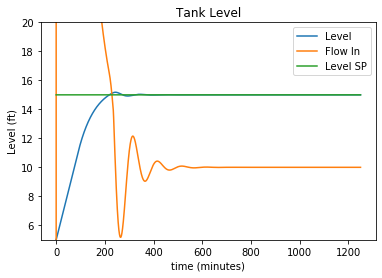

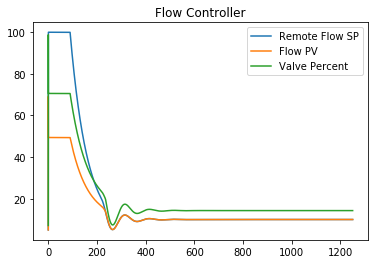

In [7]:
#Goal: Set up and integrate flow controller

#####Initialize level controller######

Fout = 10   #gpm
Fin0 = 5.01
h0= 5       #ft
Frsp = 5
Fin = Fin0
h = h0

SP = 15     #ft
dt = 1      #sec
Kc = 20
Ti = 500
Kd = 0
PV = [h0]
CO = [Frsp]
#P = [0]
I=[0]
e = [0]
          
#####Initialize flow controller######
SPf = Frsp   #gpm
Kcf = 1      #
Tif = 25     #sec
Kdf = 0

Flow_in = [Fin0]
COf = [7.14]  # % 
valve_perc = 7.14
#P = [0]
If=[0]
ef = [0]
                              
lvl_controller = PID( Kc, 1/Ti, Kd, Ts=dt)   #Ts entered in sec
lvl_controller.setPoint(SP)
flow_controller = PID(Kcf, 1/Tif, Kdf, Ts=dt)
flow_controller.setPoint(SPf)

Lvl_SP = [lvl_controller.getPoint()]

time = np.arange(0, 75000)
for t in time:
#########Lvl Controller#########
    Frsp = lvl_controller.update(h)
    h =  (Fin - Fout)*(dt/60)/A + h 
    PV.append(h)
    CO.append(Frsp)
    I.append(lvl_controller.getIntegrator)
    e.append(lvl_controller.getError())
    Lvl_SP.append(lvl_controller.getPoint())

#########Flow Controller#########
    flow_controller.set_point = Frsp
    valve_perc = flow_controller.update(Fin)
    Fin =  70/100*valve_perc
    Flow_in.append(Fin)
    COf.append(valve_perc)
    If.append(flow_controller.getIntegrator)
    ef.append(flow_controller.getError())
    

PV = np.asarray(PV[:len(time)])    
CO = np.asarray(CO[:len(time)])  #This is the remote SP to the flwo controller
I = np.asarray(I[:len(time)])
e = np.asarray(e[:len(time)])
Lvl_SP = np.asarray(Lvl_SP[:len(time)])

Flow_in = np.asarray(Flow_in[:len(time)])    
COf = np.asarray(COf[:len(time)])
If = np.asarray(If[:len(time)])
ef = np.asarray(ef[:len(time)])
time_min = time/60



fig, ax = plt.subplots()
ax.plot(time_min,PV, label="Level")
ax.plot(time_min, Flow_in, label="Flow In")
ax.plot(time_min, Lvl_SP, label="Level SP")
ax.set_title("Tank Level")
ax.set_xlabel("time (minutes)")
ax.set_ylabel("Level (ft)")
#ax.set_xlim(0,len(time))
ax.set_ylim(5,20)
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(time_min,CO, label = 'Remote Flow SP')
ax.plot(time_min, Flow_in, label = "Flow PV")
ax.plot(time_min, COf, label = "Valve Percent")
ax.set_title("Flow Controller")
#ax.set_ylim(0,20)
plt.legend()
plt.show()

A bit better. As expected, 150s was far too much integral time on an already integrating system. Shifting the control action to the P calculation greatly alleviated the oscillations. But, we still see inner loop saturation.

In [ ]:
x = ([0,0,0],[0,1,0])
x = np.asarray(x)
print(x)

print(len(x))
#y = [0:5]
#print(y)

for i in range(len(x)):
    print(i)
    
    
y = [5,5,5,0]
print(y.index(min(y)))

a = 5
b = 6

center = [a,b]; print(center)

print(5/2)

In [6]:
image = np.zeros( (10,10) )
image[0,6] = 1
image[1,5] = 1; image[1,7] = 1
image[2,4] = 1; image[2,8] = 1
image[3,3] = 1; image[3,9] = 1
image[4,4] = 1; image[4,8] = 1
image[5,5] = 1; image[5,7] = 1
image[6,6] = 1; image[6,8] = 1
image[7,7] = 1
print(image)

image = np.asarray(image)
row_cts = []
col_cts = []

for i in range(len(image)):                #locat the row and column containing the center

    ones_in_rowi = np.where(image[i,:] == 1)[0].tolist()    #get the indices of all 1's in the row
    if len(ones_in_rowi) > 1:                #count how far away the first and last 1s are
        row_diff = ones_in_rowi[-1] - ones_in_rowi[0] 
    else:
        row_diff = 0
    row_cts.append(row_diff)                 #make alist of the gaps
                                             #do the same for the columns
    ones_in_coli = np.where(image[:,i] == 1)[0].tolist()
    if len(ones_in_coli) > 1:
        col_diff = ones_in_coli[-1] - ones_in_coli[0] 
    else:
        col_diff = 0
    col_cts.append(col_diff)
                                            #we now have all the info we need for finding the center...extract it:
center_row = row_cts.index(max(row_cts))
center_col = col_cts.index(max(col_cts))
center = [center_row, center_col]; print("\nCenter: (index begins at 0)");print(center) 


print("\n\n\n")
print(row_cts)
test = np.where(image[2,:] == 1)
print(test)
print(test[0])

print(test[0].tolist())

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Center: (index begins at 0)
[3, 6]




[0, 2, 4, 6, 4, 2, 2, 0, 0, 0]
(array([4, 8], dtype=int64),)
[4 8]
[4, 8]


In [9]:
vector = list(range(11)); print(vector)
for i in vector:
    if i % 3 == 0:
        vector[i] = "Tic"
    else:
        if i % 5 == 0:
            vector[i] = "toc"
        else:
            continue
    
print(vector)


vector = list(range(16)); print(vector)
for i in vector:
    if (i % 3 == 0) & (i % 5 == 0):
        vector[i] = "tictoc"
    elif i % 3 == 0:
        vector[i] = "tic"
    else:
        if i % 5 == 0:
            vector[i] = "toc"
        else:
            vector[i] = i 
    
print(vector)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
['Tic', 1, 2, 'Tic', 4, 'toc', 'Tic', 7, 8, 'Tic', 'toc']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
['tictoc', 1, 2, 'tic', 4, 'toc', 'tic', 7, 8, 'tic', 'toc', 11, 'tic', 13, 14, 'tictoc']


In [23]:
pwd

'C:\\python\\Jupyters\\Control_Theory'